# Benchmark Analysis - H6

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple

%matplotlib inline

In [3]:
matplotlib.style.use('seaborn-v0_8')  

In [4]:
root_dir = '/Users/diego/Desktop/BENCHMARK_NEBULAC_ALL_67M'

In [5]:
GCC_TBB_COLOR = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'

NVC_OMP_COLOR = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'

NVC_GPU_COLOR = 'beige'


In [6]:
plot_save_dir = './plots/h6'

## Utils 

In [7]:
def get_path(*entries):
    return os.path.join(*entries)

In [8]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [9]:
def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"))
    plt.show()

In [10]:
def extraction_pandas_frame_algo(path, COMP="TODO"):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'bytes_per_second', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                 axis=1)

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 3 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 3 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id'], axis=1)
    results_gcc['Compiler'] = COMP
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [11]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '67108864', COMP:str="TODO") -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [12]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [13]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [14]:
def par_data_algo(compiler_location:str,compiler_name:str,bench_name:str) -> pd.DataFrame:
    # load bench_name
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{bench_name}_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df

In [15]:
def get_strong_scaling_algo(compiler_location:str,compiler_name:str,bench_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = extraction_pandas_frame_algo(f'{root_dir}/{compiler_location}/DEFAULT/{bench_name}_seq__Default.csv',
                                            COMP=compiler_name)
    
    ## threaded
    df = extraction_pandas_frame_algo_threaded(f'{root_dir}/{compiler_location}/THREADS',
                                               f'{bench_name}_par',
                                               [1,2,4,8,16,32,64],
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")

# H6
> Parallel STL backends leverage specialized parallelism techniques for inclusive and exclusive scans, resulting in
> significant variations in performance and strong scaling properties.

## `b6_1_inclusive_scan_par`

In [16]:
benchmark_name = "b6_1_inclusive_scan"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b6_1_inclusive_scan_par`

Check how the runtime without constraining the threads develops with increasing input size

In [17]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b6_1_inclusive_scan_time_merged = pd.merge(*data, on='n')

b6_1_inclusive_scan_time_merged

,GCC(TBB),n,NVC(OMP)
0,4681.11,4,3.018070e+02
1,14028.80,8,3.021000e+02
2,27222.70,16,3.046540e+02
3,37833.90,32,3.136690e+02
4,46177.60,64,3.325790e+02
5,53053.00,128,3.733240e+02
6,57671.10,256,4.353400e+02
7,63335.20,512,5.903860e+02
8,68344.30,1024,8.552200e+02
9,75378.50,2048,1.362650e+03


### Strong Scaling - `b6_1_inclusive_scan_strong_par`
 
2^26 fixed input size with threads 1-64

In [18]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b6_1_inclusive_scan_strong_scaling_merged = pd.merge(*data, on='threads')

b6_1_inclusive_scan_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.014048,1.109413
1,2,1.043677,1.106791
2,4,0.995777,1.108697
3,8,0.915938,1.104181
4,16,0.908694,1.108005
5,32,0.896909,1.106886
6,64,0.911127,1.109776


In [19]:
## efficiency graph

b6_1_inclusive_scan_efficiency = b6_1_inclusive_scan_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b6_1_inclusive_scan_efficiency[f'{compiler_name}'] = b6_1_inclusive_scan_efficiency[f'{compiler_name}'] / b6_1_inclusive_scan_efficiency['threads']



b6_1_inclusive_scan_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.014048,1.109413
1,2,0.521838,0.553396
2,4,0.248944,0.277174
3,8,0.114492,0.138023
4,16,0.056793,0.069250
5,32,0.028028,0.034590
6,64,0.014236,0.017340


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_7901/3583944337.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


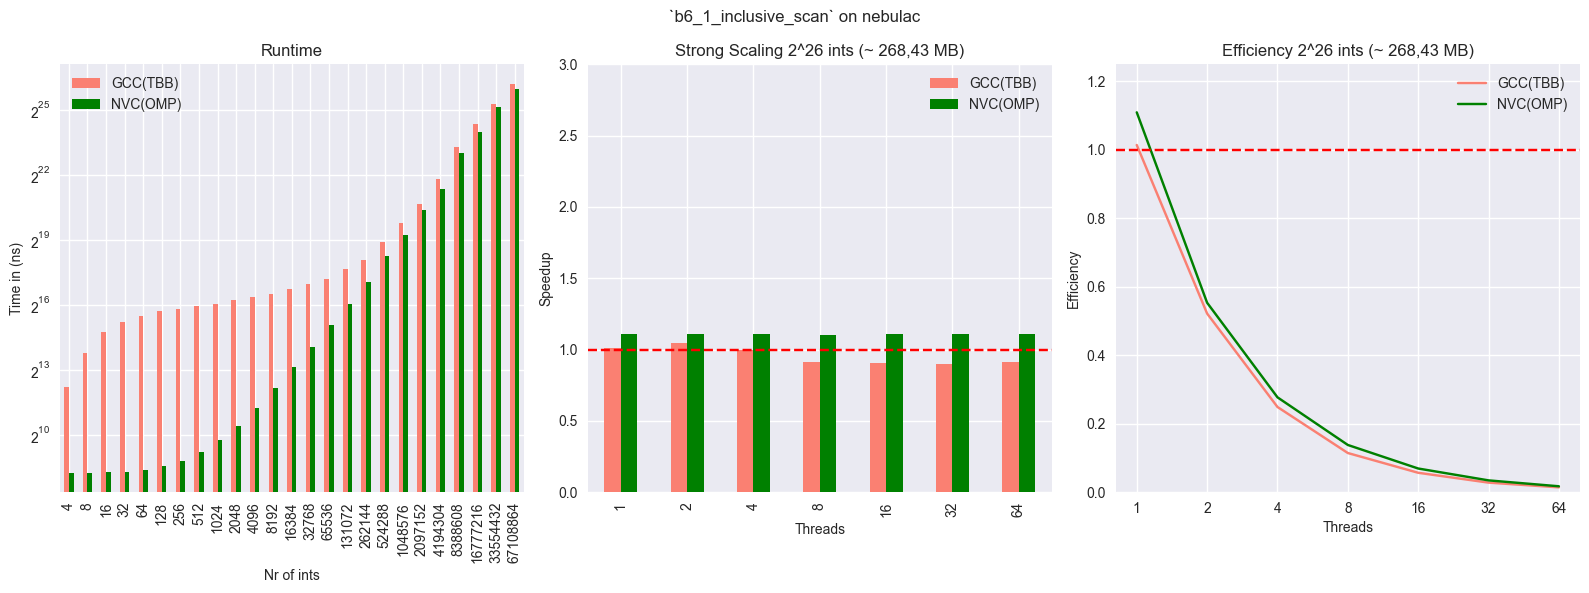

In [30]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b6_1_inclusive_scan_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b6_1_inclusive_scan_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b6_1_inclusive_scan_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b6_1_inclusive_scan` on nebulac")

fig.tight_layout()

plot("`b6_1_inclusive_scan` nebulac")

## `b6_2_exclusive_scan_par`

In [21]:
benchmark_name = "b6_2_exclusive_scan"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b6_2_exclusive_scan_par`

Check how the runtime without constraining the threads develops with increasing input size

In [22]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b6_2_exclusive_scan_time_merged = pd.merge(*data, on='n')

b6_2_exclusive_scan_time_merged

,GCC(TBB),n,NVC(OMP)
0,11312.0,4,2.988070e+02
1,22179.3,8,2.994870e+02
2,32319.2,16,3.049390e+02
3,42234.8,32,3.050090e+02
4,50140.7,64,3.350330e+02
5,57080.6,128,3.778040e+02
6,60361.5,256,4.377960e+02
7,67469.2,512,5.904230e+02
8,75623.2,1024,8.568240e+02
9,82081.8,2048,1.362440e+03


### Strong Scaling - `b6_2_exclusive_scan_strong_par`
 
2^26 fixed input size with threads 1-64

In [23]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b6_2_exclusive_scan_strong_scaling_merged = pd.merge(*data, on='threads')

b6_2_exclusive_scan_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.002904,1.106949
1,2,1.040544,1.109051
2,4,1.014566,1.106236
3,8,0.945620,1.104099
4,16,0.940718,1.108877
5,32,0.901645,1.103807
6,64,0.880771,1.099941


In [24]:
## efficiency graph

b6_2_exclusive_scan_efficiency = b6_2_exclusive_scan_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b6_2_exclusive_scan_efficiency[f'{compiler_name}'] = b6_2_exclusive_scan_efficiency[f'{compiler_name}'] / b6_2_exclusive_scan_efficiency['threads']



b6_2_exclusive_scan_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.002904,1.106949
1,2,0.520272,0.554525
2,4,0.253641,0.276559
3,8,0.118203,0.138012
4,16,0.058795,0.069305
5,32,0.028176,0.034494
6,64,0.013762,0.017187


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_7901/3871977296.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


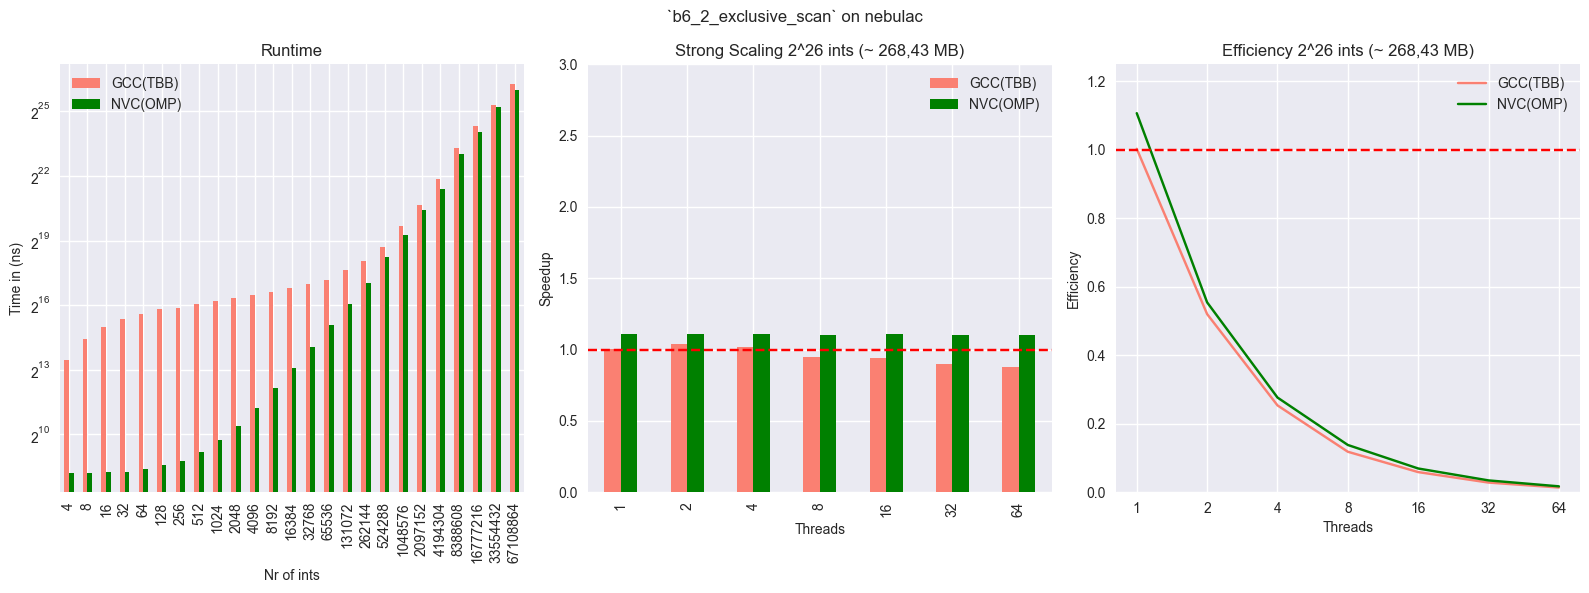

In [31]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b6_2_exclusive_scan_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b6_2_exclusive_scan_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b6_2_exclusive_scan_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b6_2_exclusive_scan` on nebulac")

fig.tight_layout()

plot("`b6_2_exclusive_scan` nebulac")

######################## DIVIDER ########################

## Performance Portability Calculation (Inter Compiler)

TODO

In [26]:
# calc pp_metrics


## Findings for H6

### XXX

### General


### GPU Findings


### Hypothesis Findings


